# Le relazioni tra variabili

**Prerequisiti**

**Punti chiave**

Al termine di questo capitolo, gli studenti saranno in grado di:

- Calcolare la correlazione e la covarianza;
- Interpretare gli indici di correlazione e covarianza.

**Preparazione del Notebook**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import arviz as az

In [2]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "correlation"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

## Introduzione

Nel linguaggio comune, termini quali "dipendenza", "associazione" e "correlazione" sono spesso utilizzati in modo intercambiabile. Tuttavia, da un punto di vista tecnico, "associazione" e "dipendenza" sono sinonimi e entrambi si distinguono dalla "correlazione". L'associazione implica una relazione molto ampia: conoscere il valore di una variabile ci fornisce informazioni su un'altra variabile. Al contrario, la correlazione descrive una relazione più specifica e quantificabile, indicando se due variabili tendono a variare insieme in modo sistematico; ad esempio, in una tendenza crescente, se $ X > \mu_X $ allora è probabile che anche $ Y > \mu_Y $.

È cruciale comprendere che non tutte le associazioni sono correlazioni e che, crucialmente, la correlazione non implica causalità. Questa distinzione è vitale per interpretare accuratamente i dati e per evitare conclusioni errate sulle relazioni tra variabili.

In questo capitolo, ci concentreremo su due misure statistiche fondamentali per valutare la relazione lineare tra due variabili: la covarianza e la correlazione. Questi strumenti sono essenziali per analizzare il grado e la direzione dell'associazione lineare tra le variabili, permettendoci di quantificare in che modo le variabili variano congiuntamente.

## I dati grezzi

Per illustrare la correlazione e la covarianza, analizzeremo i dati raccolti da @zetsche_2019future in uno studio che indaga le aspettative negative come meccanismo chiave nel mantenimento e nella reiterazione della depressione. Nello specifico, i ricercatori si sono proposti di determinare se gli individui depressi sviluppano aspettative accurate riguardo al loro umore futuro o se tali aspettative sono distortamente negative.

Uno dei loro studi ha coinvolto un campione di 30 soggetti con almeno un episodio depressivo maggiore, confrontati con un gruppo di controllo composto da 37 individui sani. La misurazione del livello di depressione è stata effettuata tramite il *Beck Depression Inventory* (BDI-II).

Il BDI-II è uno strumento di autovalutazione utilizzato per valutare la gravità della depressione in adulti e adolescenti. Il test è stato sviluppato per identificare e misurare l'intensità dei sintomi depressivi sperimentati nelle ultime due settimane. I 21 item del test sono valutati su una scala a 4 punti, dove 0 rappresenta il grado più basso e 3 il grado più elevato di sintomatologia depressiva. 

Nell'esercizio successivo, ci proponiamo di analizzare i punteggi di depressione BDI-II nel campione di dati fornito da @zetsche_2019future.

## Definizione delle relazioni tra variabili

Nel contesto delle indagini statistiche, spesso non ci limitiamo a esaminare la distribuzione di una singola variabile. Invece, il nostro interesse si concentra sulla relazione che emerge nei dati tra due o più variabili. Ma cosa significa esattamente quando diciamo che due variabili hanno una relazione?

Per comprendere ciò, prendiamo ad esempio l'altezza e l'età tra un gruppo di bambini. In generale, è possibile notare che all'aumentare dell'età di un bambino, aumenta anche la sua altezza. Pertanto, conoscere l'età di un bambino, ad esempio tredici anni, e l'età di un altro, sei anni, ci fornisce un'indicazione su quale dei due bambini sia più alto.

Nel linguaggio statistico, definiamo questa relazione tra altezza e età come positiva, il che significa che all'aumentare dei valori di una delle variabili (in questo caso, l'età), ci aspettiamo di vedere valori più elevati anche nell'altra variabile (l'altezza). Tuttavia, esistono anche relazioni negative, in cui l'aumento di una variabile è associato a un diminuzione dell'altra (ad esempio, più età è correlata a meno pianto).

Non si tratta solo di relazioni positive o negative; ci sono anche situazioni in cui le variabili non hanno alcuna relazione tra loro, definendo così una relazione nulla. Inoltre, le relazioni possono variare nel tempo, passando da positive a negative o da fortemente positive a appena positiva. In alcuni casi, una delle variabili può essere categorica, rendendo difficile parlare di "maggioranza" o "minoranza" ma piuttosto di "differente" (ad esempio, i bambini più grandi potrebbero semplicemente avere diverse preferenze rispetto ai bambini più piccoli, senza necessariamente essere "migliori" o "peggiori").

## Grafico a dispersione {#sec-scatter-plot}

Il metodo più diretto per visualizzare la relazione tra due variabili continue è tramite un grafico a dispersione, comunemente noto come "scatterplot". Questo tipo di diagramma rappresenta le coppie di dati ottenute da due variabili, posizionandole sull'asse delle ascisse (orizzontale) e delle ordinate (verticale).

Per rendere l'idea più chiara, consideriamo i dati dello studio condotto da @zetsche_2019future, in cui i ricercatori hanno utilizzato due scale psicometriche, il Beck Depression Inventory II (BDI-II) e la Center for Epidemiologic Studies Depression Scale (CES-D), per misurare il livello di depressione nei partecipanti. Il BDI-II è uno strumento di autovalutazione che valuta la presenza e l'intensità dei sintomi depressivi in pazienti adulti e adolescenti con diagnosi psichiatrica, mentre la CES-D è una scala di autovalutazione progettata per misurare i sintomi depressivi sperimentati nella settimana precedente nella popolazione generale, in particolare negli adolescenti e nei giovani adulti. Poiché entrambe le scale misurano lo stesso costrutto, ovvero la depressione, ci aspettiamo una relazione tra i punteggi ottenuti dal BDI-II e dalla CES-D. Un diagramma a dispersione ci consente di esaminare questa relazione in modo visuale e intuitivo.

In [3]:
# Leggi i dati dal file CSV
df = pd.read_csv("../../data/data.mood.csv", index_col=0)

# Seleziona le colonne di interesse
df = df[["esm_id", "group", "bdi", "cesd_sum"]]

# Rimuovi le righe duplicate
df = df.drop_duplicates(keep="first")

# Rimuovi le righe con valori mancanti nella colonna "bdi"
df = df.dropna(subset=["bdi"])

Posizionando i valori del BDI-II sull'asse delle ascisse e quelli del CES-D sull'asse delle ordinate, ogni punto sul grafico rappresenta un individuo, di cui conosciamo il livello di depressione misurato dalle due scale. È evidente che i valori delle scale BDI-II e CES-D non possono coincidere per due motivi principali: (1) la presenza di errori di misurazione e (2) l'utilizzo di unità di misura arbitrarie per le due variabili. L'errore di misurazione è una componente inevitabile che influisce in parte su qualsiasi misurazione, ed è particolarmente rilevante in psicologia, dove la precisione degli strumenti di misurazione è generalmente inferiore rispetto ad altre discipline, come la fisica. Il secondo motivo per cui i valori delle scale BDI-II e CES-D non possono essere identici è che l'unità di misura della depressione è una questione arbitraria e non standardizzata. Tuttavia, nonostante le differenze dovute agli errori di misurazione e all'uso di unità di misura diverse, ci aspettiamo che, se le due scale misurano lo stesso costrutto (la depressione), i valori prodotti dalle due scale dovrebbero essere associati linearmente tra di loro. Per comprendere meglio il concetto di "associazione lineare", è possibile esaminare i dati attraverso l'utilizzo di un diagramma a dispersione.

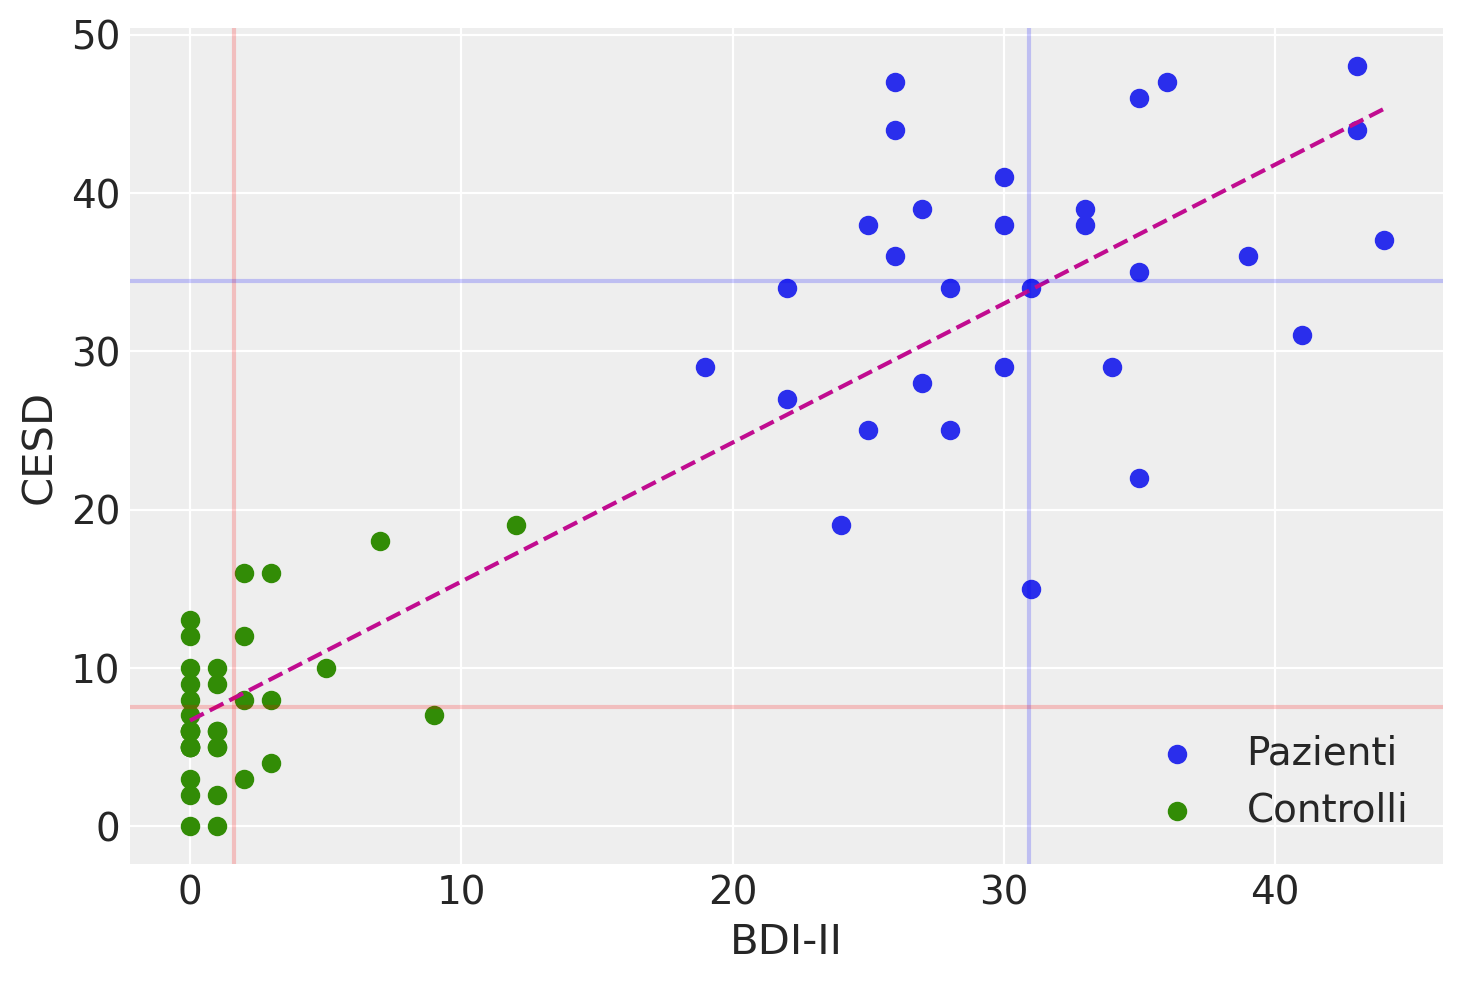

In [4]:
# Crea uno scatterplot con colori diversi per i due gruppi
plt.scatter(df[df["group"] == "mdd"]["bdi"], df[df["group"] == "mdd"]["cesd_sum"], label="Pazienti", c="C0")
plt.scatter(df[df["group"] == "ctl"]["bdi"], df[df["group"] == "ctl"]["cesd_sum"], label="Controlli", c="C2")

# Calcola i coefficienti della retta dei minimi quadrati
coeff_combined = np.polyfit(df["bdi"], df["cesd_sum"], 1)

# Calcola la retta dei minimi quadrati
line_combined = np.poly1d(coeff_combined)

# Disegna la retta dei minimi quadrati
x_values = np.linspace(df["bdi"].min(), df["bdi"].max(), 100)
plt.plot(x_values, line_combined(x_values), linestyle='--', color='C3')

# Etichette degli assi
plt.xlabel("BDI-II")
plt.ylabel("CESD")

# Linee verticali ed orizzontali per le medie
plt.axvline(np.mean(df[df["group"] == "mdd"]["bdi"]), alpha=0.2, color="blue")
plt.axvline(np.mean(df[df["group"] == "ctl"]["bdi"]), alpha=0.2, color="red")
plt.axhline(np.mean(df[df["group"] == "mdd"]["cesd_sum"]), alpha=0.2, color="blue")
plt.axhline(np.mean(df[df["group"] == "ctl"]["cesd_sum"]), alpha=0.2, color="red")

# Legenda
plt.legend()

# Mostra il grafico
plt.show()

Osservando il grafico a dispersione, è evidente che i dati mostrano una tendenza a distribuirsi in modo approssimativamente lineare. In termini statistici, ciò suggerisce una relazione di associazione lineare tra i punteggi CES-D e BDI-II.

Tuttavia, è importante notare che la relazione lineare tra le due variabili è lontana dall'essere perfetta. In una relazione lineare perfetta, tutti i punti nel grafico sarebbero allineati in modo preciso lungo una retta. Nella realtà, la dispersione dei punti dal comportamento lineare ideale è evidente.

Di conseguenza, sorge la necessità di quantificare numericamente la forza e la direzione della relazione lineare tra le due variabili e di misurare quanto i punti si discostino da una relazione lineare ideale. Esistono vari indici statistici a disposizione per raggiungere questo obiettivo.

## Covarianza

Iniziamo a considerare il più importante di tali indici, chiamato *covarianza*. In realtà la definizione di questo indice non ci sorprenderà più di tanto in quanto, in una forma solo apparentemente diversa, l'abbiamo già incontrata in precedenza. Ci ricordiamo infatti che la varianza di una generica variabile $X$ è definita come la media degli scarti quadratici di ciascuna osservazione dalla media:

$$
S_{XX} = \frac{1}{n} \sum_{i=1}^n(X_i - \bar{X}) (X_i - \bar{X}). 
$$

La varianza viene talvolta descritta come la "covarianza di una variabile con sé stessa". Adesso facciamo un passo ulteriore. Invece di valutare la dispersione di una sola variabile, ci chiediamo come due variabili $X$ e $Y$ "variano insieme" (co-variano). È facile capire come una risposta a tale domanda possa essere fornita da una semplice trasformazione della formula precedente che diventa:

$$
S_{XY} = \frac{1}{n} \sum_{i=1}^n(X_i - \bar{X}) (Y_i - \bar{Y}).
$$ {#eq-cov-def}

L'@eq-cov-def ci fornisce la definizione della covarianza.

### Interpretazione

Per capire il significato dell'@eq-cov-def, supponiamo di dividere il grafico riportato nella @sec-introduction in quattro quadranti definiti da una retta verticale passante per la media dei valori BDI-II e da una retta orizzontale passante per la media dei valori CES-D. Numeriamo i quadranti partendo da quello in basso a sinistra e muovendoci in senso antiorario.

Se prevalgono punti nel I e III quadrante, allora la nuvola di punti avrà un andamento crescente (per cui a valori bassi di $X$ tendono ad associarsi valori bassi di $Y$ e a valori elevati di $X$ tendono ad associarsi valori elevati di $Y$) e la covarianza avrà segno positivo. Mentre se prevalgono punti nel II e IV quadrante la nuvola di punti avrà un andamento decrescente (per cui a valori bassi di $X$ tendono ad associarsi valori elevati di $Y$ e a valori elevati di $X$ tendono ad associarsi valori bassi di $Y$) e la covarianza avrà segno negativo. Dunque, il segno della covarianza ci informa sulla direzione della relazione lineare tra due variabili: l'associazione lineare si dice positiva se la covarianza è positiva, negativa se la covarianza è negativa.

**Esercizio.** Implemento l'@eq-cov-def in Python.

In [6]:
def cov_value(x, y):

    mean_x = sum(x) / float(len(x))
    mean_y = sum(y) / float(len(y))

    sub_x = [i - mean_x for i in x]
    sub_y = [i - mean_y for i in y]

    sum_value = sum([sub_y[i] * sub_x[i] for i in range(len(x))])
    denom = float(len(x))

    cov = sum_value / denom
    return cov

Per i dati mostrati nel diagramma, la covarianza tra BDI-II e CESD è 207.4

In [7]:
x = df["bdi"]
y = df["cesd_sum"]

cov_value(x, y)

207.42653810835637

Oppure, in maniera più semplice:

In [8]:
np.mean((x - np.mean(x)) * (y - np.mean(y)))

207.42653810835628

Lo stesso risultato si ottiene con la funzione `cov` di NumPy.

In [9]:
np.cov(x, y, ddof=0)

array([[236.23875115, 207.42653811],
       [207.42653811, 222.83379247]])

La funzione `np.cov(x, y, ddof=0)` in Python, utilizzata tramite la libreria NumPy, calcola la covarianza tra due array, `x` e `y`. L'argomento `ddof` (Delta Degrees of Freedom) specifica il "correttore" da applicare al denominatore della formula di covarianza.

Quando si imposta `ddof=0`, la formula utilizzata per il calcolo della covarianza divide la somma dei prodotti delle deviazioni dalla media per `n`, dove `n` è il numero totale degli elementi nel campione (ovvero, la dimensione del campione). Questo approccio assume che i dati forniti rappresentino l'intera popolazione da cui si vuole stimare la covarianza, producendo una stima non corretta (bias) se i dati sono effettivamente un campione di una popolazione più ampia. Il "bias" in questo contesto si riferisce al fatto che la stima tende sistematicamente a essere più piccola rispetto alla vera covarianza della popolazione da cui il campione è stato estratto.

Per correggere questo errore sistematico e ottenere una stima non distorta (unbiased) della covarianza di una popolazione più ampia basandosi su un campione, si utilizza `ddof=1`. Questo significa che al denominatore della formula si sottrae 1 a `n`, dividendo quindi per `n-1`. Il correttore `n-1` è noto come correttore di Bessel, e l'uso di `ddof=1` rende la stima della covarianza non distorta nel contesto di un campione prelevato da una popolazione. La correzione è importante in statistica perché fornisce una stima più accurata delle proprietà della popolazione, soprattutto quando la dimensione del campione è piccola.

In sintesi:
- Con `ddof=0`, si divide per `n`, assumendo che i dati rappresentino l'intera popolazione. Questo può introdurre un bias nella stima della covarianza se i dati sono in realtà un campione.
- Con `ddof=1`, si divide per `n-1`, correggendo il bias e ottenendo una stima non distorta (unbiased) della covarianza se i dati rappresentano un campione di una popolazione più grande. Questo approccio è generalmente preferito per la stima delle proprietà della popolazione basata su campioni.

## Correlazione

La direzione della relazione tra le variabili è indicata dal segno della covarianza, ma il valore assoluto di questo indice non fornisce informazioni utili poiché dipende dall'unità di misura delle variabili. Ad esempio, considerando l'altezza e il peso delle persone, la covarianza sarà più grande se l'altezza è misurata in millimetri e il peso in grammi, rispetto al caso in cui l'altezza è in metri e il peso in chilogrammi. Pertanto, per descrivere la forza e la direzione della relazione lineare tra due variabili in modo adimensionale, si utilizza l'indice di correlazione.

La correlazione è ottenuta standardizzando la covarianza tramite la divisione delle deviazioni standard ($s_X$, $s_Y$) delle due variabili:

$$ 
r_{XY} = \frac{S_{XY}}{S_X S_Y}. 
$$ {#eq-cor-def}

La quantità che si ottiene dall'@eq-cor-def viene chiamata *correlazione* di Bravais-Pearson (dal nome degli autori che, indipendentemente l'uno dall'altro, l'hanno introdotta).

### Proprietà

Il coefficiente di correlazione ha le seguenti proprietà:

-   ha lo stesso segno della covarianza, dato che si ottiene dividendo la covarianza per due numeri positivi;
-   è un numero puro, cioè non dipende dall'unità di misura delle variabili;
-   assume valori compresi tra -1 e +1.

### Interpretazione  

All'indice di correlazione possiamo assegnare la seguente interpretazione:

1.  $r_{XY} = -1$ $\rightarrow$ perfetta relazione negativa: tutti i punti si trovano esattamente su una retta con pendenza negativa (dal quadrante in alto a sinistra al quadrante in basso a destra);
2.  $r_{XY} = +1$ $\rightarrow$ perfetta relazione positiva: tutti i punti si trovano esattamente su una retta con pendenza positiva (dal quadrante in basso a sinistra al quadrante in alto a destra);
3.  $-1 < r_{XY} < +1$ $\rightarrow$ presenza di una relazione lineare di intensità diversa;
4.  $r_{XY} = 0$ $\rightarrow$ assenza di relazione lineare tra $X$ e $Y$.

**Esercizio.** Per i dati riportati nel diagramma della sezione {ref}`sec-zetsche-scatter`, la covarianza è 207.4. Il segno positivo della covarianza ci dice che tra le due variabili c'è un'associazione lineare positiva. Per capire quale sia l'intensità della relazione lineare calcoliamo la correlazione. Essendo le deviazioni standard del BDI-II e del CES-D rispettavamente uguali a 15.37 e 14.93, la correlazione diventa uguale a $\frac{207.426}{15.38 \cdot 14.93} = 0.904.$ Tale valore è prossimo a 1.0, il che vuol dire che i punti del diagramma a dispersione non si discostano troppo da una retta con una pendenza positiva.

Troviamo la correlazione con la funzione `corrcoef()`:

In [9]:
np.corrcoef(x, y)

array([[1.        , 0.90406202],
       [0.90406202, 1.        ]])

Replichiamo il risultato implementando l'eq. {eq}`eq-cor-def`: 

In [10]:
s_xy = np.mean((x - np.mean(x)) * (y - np.mean(y)))
s_x = x.std(ddof=0)
s_y = y.std(ddof=0)
r_xy = s_xy / (s_x * s_y)
print(r_xy)

0.9040620189474861


Un altro modo ancora per trovare la correlazione tra i punteggi BDI-II e CESD è quello di standardizzare le due variabili per poi applicare la formula della covarianza:

In [11]:
z_x = (x - np.mean(x)) / np.std(x, ddof=0)
z_y = (y - np.mean(y)) / np.std(y, ddof=0)
np.mean(z_x * z_y)

0.9040620189474862

**Esempio.** Un uso interessante delle correlazioni viene fatto in un recente articolo di [Guilbeault et al. (2024)](https://www.nature.com/articles/s41586-024-07068-x). Il concetto di "gender bias" si riferisce alla tendenza sistematica di favorire un sesso rispetto all'altro, spesso a scapito delle donne. Lo studio di Guilbeault et al. (2024) analizza come le immagini online influenzino la diffusione su vasta scala di questo preconcetto di genere.

Attraverso un vasto insieme di immagini e testi raccolti online, gli autori dimostrano che sia le misurazioni basate sulle immagini che quelle basate sui testi catturano la frequenza con cui varie categorie sociali sono associate a rappresentazioni di genere, valutate su una scala da -1 (femminile) a 1 (maschile), con 0 che indica una neutralità di genere. Questo consente di quantificare il preconcetto di genere come una forma di bias statistico lungo tre dimensioni: la tendenza delle categorie sociali ad associarsi a un genere specifico nelle immagini e nei testi, la rappresentazione relativa delle donne rispetto agli uomini in tutte le categorie sociali nelle immagini e nei testi, e il confronto tra le associazioni di genere nei dati delle immagini e dei testi con la distribuzione empirica delle donne e degli uomini nella società. Il lavoro di Guilbeault et al. (2024) evidenzia che il preconcetto di genere è molto più evidente nelle immagini rispetto ai testi, come mostrato nella {numref}`gender-bias-1-fig` C. 

Si noti che, nel grafico della {numref}`gender-bias-1-fig` C, ogni punto può essere interpretato come una misura di correlazione. La misura utilizzata da Guilbeault et al. (2024) riflette il grado di associazione tra le categorie sociali e le rappresentazioni di genere presenti nelle immagini e nei testi analizzati. Quando la misura è vicina a +1, indica una forte associazione positiva tra una categoria sociale specifica e una rappresentazione di genere maschile, mentre un valore vicino a -1 indica una forte associazione negativa con una rappresentazione di genere femminile. Un valore di 0, invece, suggerisce che non vi è alcuna associazione tra la categoria sociale considerata e un genere specifico, indicando una sorta di neutralità di genere. In sostanza, questa misura di frequenza può essere interpretata come una correlazione che riflette la tendenza delle categorie sociali a essere rappresentate in un modo o nell'altro nelle immagini e nei testi analizzati, rispetto ai concetti di genere femminile e maschile.

![Il preconcetto di genere è più prevalente nelle immagini online (da Google Immagini) e nei testi online (da Google News). A. La correlazione tra le associazioni di genere nelle immagini da Google Immagini e nei testi da Google News per tutte le categorie sociali (n = 2.986), organizzate per decili. B. La forza dell'associazione di genere in queste immagini e testi online per tutte le categorie (n = 2.986), suddivisa in base al fatto che queste categorie siano inclinate verso il femminile o il maschile. C. Le associazioni di genere per un campione di occupazioni secondo queste immagini e testi online; questo campione è stato selezionato manualmente per evidenziare i tipi di categorie sociali e preconcetti di genere esaminati. (Figura tratta da Guilbeault et al. (2024)).](../../figures/gender_bias_1.png)


## Correlazione di Spearman

Un'alternativa per valutare la relazione lineare tra due variabili è il coefficiente di correlazione di Spearman, che si basa esclusivamente sull'ordine dei dati e non sugli specifici valori. Questo indice di associazione è particolarmente adatto quando gli psicologi sono in grado di misurare solo le relazioni di ordine tra diverse modalità di risposta dei soggetti, ma non l'intensità della risposta stessa. Tali variabili psicologiche che presentano questa caratteristica sono definite come "ordinali".

::: {.callout-note}
È importante ricordare che, nel caso di una variabile ordinale, non è possibile utilizzare le statistiche descrittive convenzionali come la media e la varianza per sintetizzare le osservazioni. Tuttavia, è possibile riassumere le osservazioni attraverso una distribuzione di frequenze delle diverse modalità di risposta. Come abbiamo appena visto, la direzione e l'intensità dell'associazione tra due variabili ordinali possono essere descritte utilizzando il coefficiente di correlazione di Spearman.
:::

Per fornire un esempio, consideriamo due variabili di scala ordinale e calcoliamo la correlazione di Spearman tra di esse.

In [12]:
stats.spearmanr([1, 2, 3, 4, 5], [5, 6, 7, 8, 7])

SignificanceResult(statistic=0.8207826816681233, pvalue=0.08858700531354381)

## Correlazione nulla

Un aspetto finale da sottolineare riguardo alla correlazione è che essa descrive la direzione e l'intensità della *relazione lineare* tra due variabili. Tuttavia, la correlazione non cattura relazioni non lineari tra le variabili, anche se possono essere molto forti. È fondamentale comprendere che una correlazione pari a zero non implica l'assenza di una relazione tra le due variabili, ma indica solamente l'assenza di una relazione lineare tra di esse.

La figura seguente fornisce tredici esempi di correlazione nulla in presenza di una chiara relazione (non lineare) tra due variabili. In questi tredici insiemi di dati i coefficienti di correlazione di Pearson sono sempre uguali a 0. Ma questo non significa che non vi sia alcuna relazione tra le variabili.

In [4]:
datasaurus_data = pd.read_csv("../data/datasaurus.csv")
datasaurus_data.groupby("dataset").agg(
    {"x": ["count", "mean", "std"], "y": ["count", "mean", "std"]}
)

x                           y                      
           count       mean        std count       mean        std
dataset                                                           
away         142  54.266100  16.769825   142  47.834721  26.939743
bullseye     142  54.268730  16.769239   142  47.830823  26.935727
circle       142  54.267320  16.760013   142  47.837717  26.930036
dino         142  54.263273  16.765142   142  47.832253  26.935403
dots         142  54.260303  16.767735   142  47.839829  26.930192
h_lines      142  54.261442  16.765898   142  47.830252  26.939876
high_lines   142  54.268805  16.766704   142  47.835450  26.939998
slant_down   142  54.267849  16.766759   142  47.835896  26.936105
slant_up     142  54.265882  16.768853   142  47.831496  26.938608
star         142  54.267341  16.768959   142  47.839545  26.930275
v_lines      142  54.269927  16.769959   142  47.836988  26.937684
wide_lines   142  54.266916  16.770000   142  47.831602  26.937902
x_shape      142  54.260150  16.769958   142  47.839717  26.930002

/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_14701/188333220.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


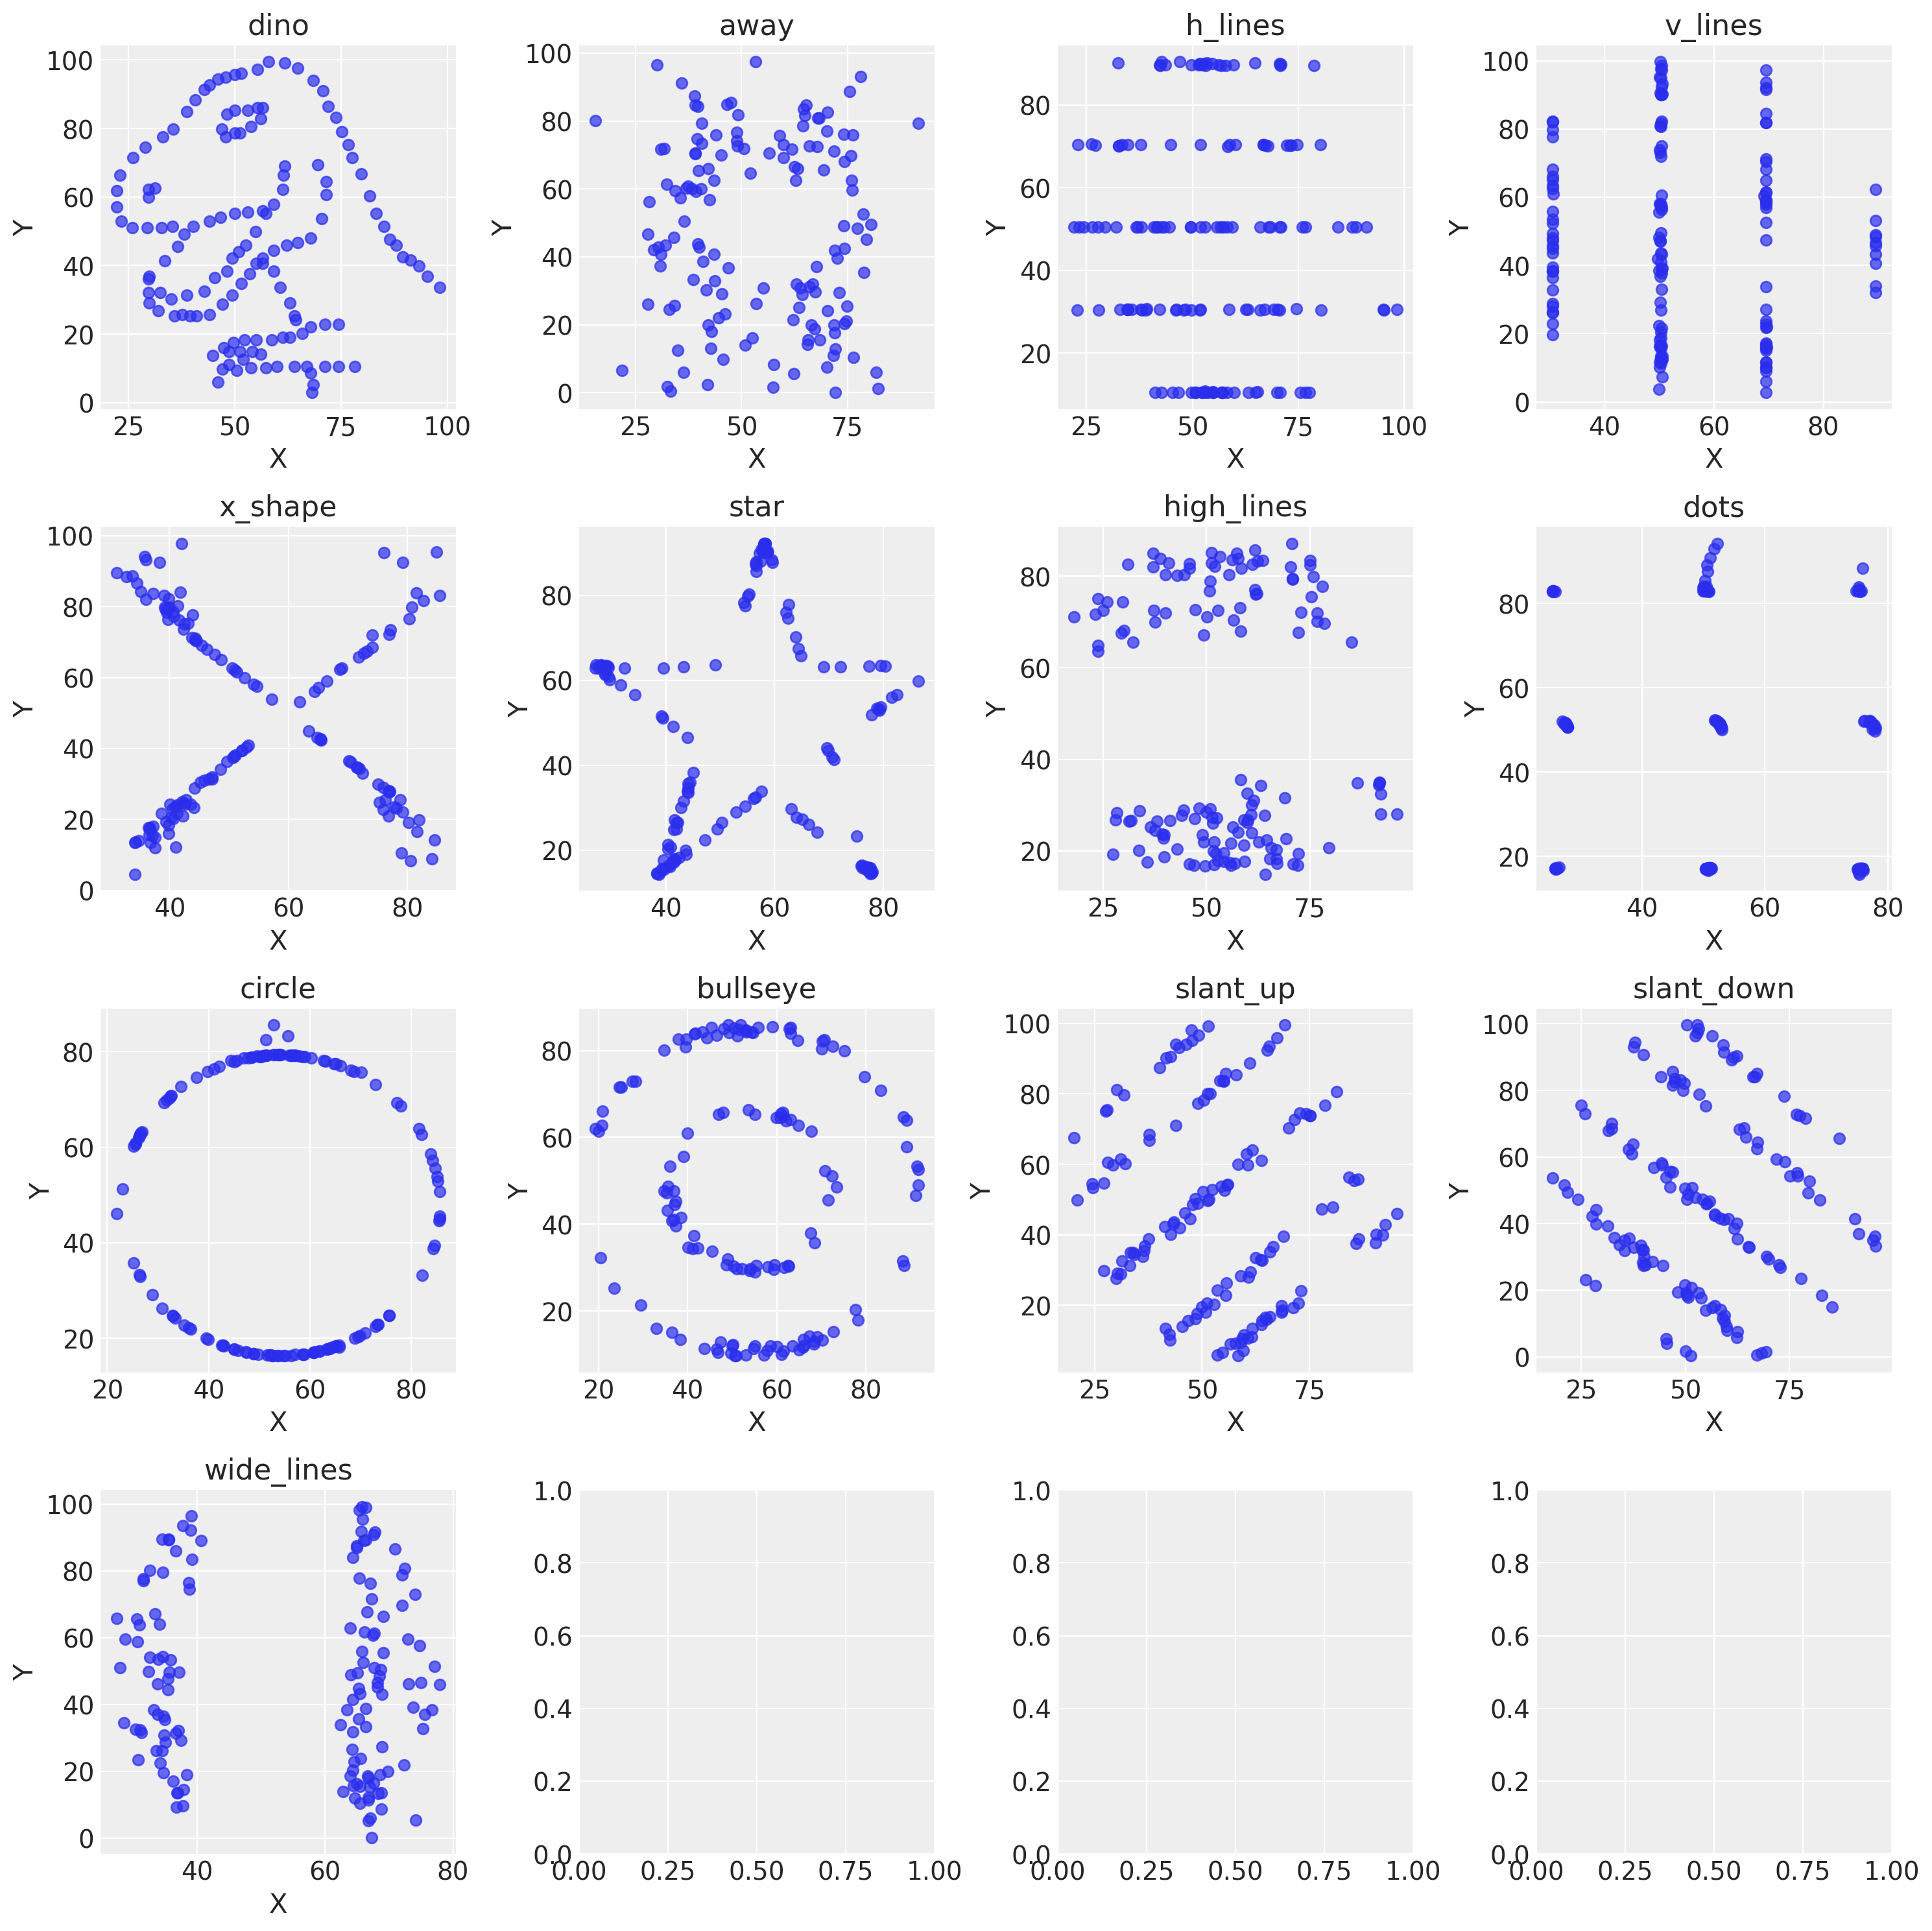

In [5]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
datasets = datasaurus_data["dataset"].unique()

for i, dataset in enumerate(datasets):
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    subset = datasaurus_data[datasaurus_data["dataset"] == dataset]
    ax.scatter(subset["x"], subset["y"], alpha=0.7)
    ax.set_title(dataset)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

plt.tight_layout()
plt.show()

## Considerazioni conclusive

Nel concludere questo capitolo dedicato allo studio di correlazione e covarianza, è essenziale mettere in evidenza alcuni principi fondamentali. Il concetto di "associazione" equivale a quello di "dipendenza" e può manifestarsi sia attraverso cause dirette che indirette. Ciò significa che variazioni in una variabile possono influenzare o essere influenzate da un'altra, indipendentemente dalla natura diretta o mediata di questo legame.

Per quanto riguarda la correlazione, questa descrive specifici tipi di associazione, come tendenze monotone. Ad esempio, la presenza di un incremento congiunto o di raggruppamenti in determinati intervalli tra due variabili è indicativa di correlazione. È però cruciale ricordare che correlazione non equivale a causalità; osservare una correlazione non implica necessariamente che una variabile causi l'altra.

Nei contesti in cui il numero di variabili è ampio rispetto alla grandezza del campione, possono emergere correlazioni elevate ma spurie. Questo accade perché un gran numero di variabili può accidentalmente generare correlazioni elevate, non riflettendo un legame sostanziale tra di esse.

D'altra parte, con un numero elevato di osservazioni, anche le correlazioni più deboli possono sembrare robuste. In campioni di grandi dimensioni, anche le più piccole variazioni possono apparire accentuate rispetto alla variabilità generale del campione, benché queste correlazioni possano non avere una rilevanza pratica.

In conclusione, è fondamentale adottare un approccio critico e ben informato nell'interpretare i risultati delle analisi di correlazione e covarianza, tenendo sempre in considerazione le dimensioni del campione e il numero di variabili coinvolte. Tale prudenza aiuta a prevenire interpretazioni errate delle relazioni tra le variabili, specialmente riguardo alla causalità.

## Informazioni sull'Ambiente di Sviluppo

In [1]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Sat Jun 08 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

Watermark: 2.4.3

